In [148]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [149]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [150]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from datetime import datetime, timedelta

In [151]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [152]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)


In [153]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [154]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [155]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [34]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Base.classes.measurement.date)).scalar()
print(most_recent_date)


2017-08-23


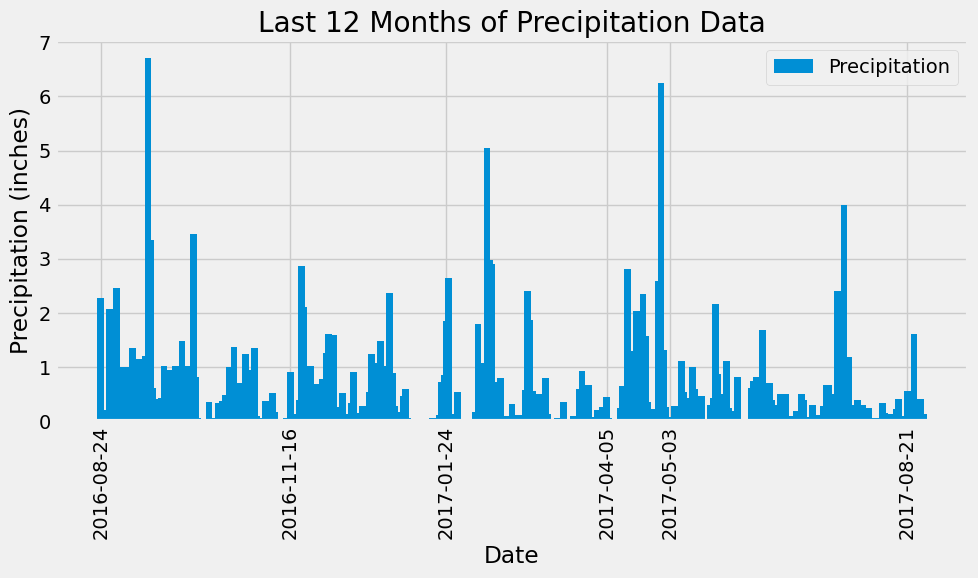

In [143]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
latest_date = datetime.strptime(session.query(func.max(Base.classes.measurement.date)).scalar(), '%Y-%m-%d')
# Calculate the date one year from the last date in data set.
one_year_ago = latest_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Base.classes.measurement.date, Base.classes.measurement.prcp).\
    filter(Base.classes.measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_df = pd.DataFrame(precipitation_data, columns=['date', 'prcp'])

# Sort the dataframe by date
prcp_df.set_index('date', inplace=True)

total_dates = len(prcp_df.index)
desired_intervals = 6 

total_months = (latest_date.year - one_year_ago.year) * (12) + (latest_date.month - one_year_ago.month)
step_size = max(total_dates // (desired_intervals - 1), 1)

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
plt.bar(prcp_df.index, prcp_df['prcp'], label='Precipitation', width=3)
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title('Last 12 Months of Precipitation Data')

# Select specific dates using the calculated step size
selected_dates_index = np.arange(0, total_dates, step_size)
selected_dates = prcp_df.index[selected_dates_index]

plt.xticks(selected_dates, rotation=90)

plt.legend()
plt.tight_layout()
plt.show()


In [99]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = prcp_df['prcp'].describe()
summary_stats_df = pd.DataFrame(summary_stats, columns=['prcp'])
summary_stats_df

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [157]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Base.classes.station.station)).scalar()
total_stations

9

In [158]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(measurement.station, func.count(measurement.station).label('station_count')).\
    group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).all()

for station, count in most_active_stations:
    print(f'Station: {station}, Count: {count}')

Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [160]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = session.query(measurement.station, func.count(measurement.station).label('station_count')).\
    group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).first()

most_active_station_id = most_active_station.station

temperature_stats = session.query(func.min(measurement.tobs).label('min_temp'),
                                  func.max(measurement.tobs).label('max_temp'),
                                  func.avg(measurement.tobs).label('avg_temp')).\
    filter(measurement.station == most_active_station_id).first()

print(f"Lowest Temperature: {temperature_stats.min_temp}")
print(f"Highest Temperature: {temperature_stats.max_temp}")
print(f"Average Temperature: {temperature_stats.avg_temp}")


Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


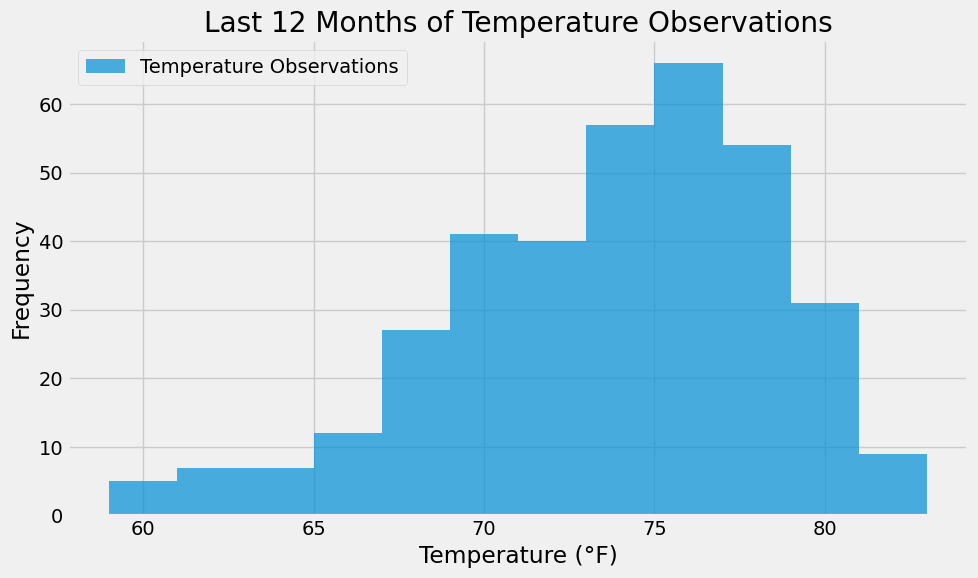

In [161]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station = session.query(measurement.station, func.count(measurement.station).label('station_count')).\
    group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).first()

most_active_station_id = most_active_station.station

latest_date = session.query(func.max(measurement.date)).filter(measurement.station == most_active_station_id).scalar()
latest_date = datetime.strptime(latest_date, '%Y-%m-%d')
one_year_ago = latest_date - timedelta(days=365)

temperature_data = session.query(measurement.date, measurement.tobs).\
    filter(measurement.station == most_active_station_id).\
    filter(measurement.date >= one_year_ago).all()

df = pd.DataFrame(temperature_data, columns=['date', 'temperature'])

plt.figure(figsize=(10, 6))
plt.hist(df['temperature'], bins=12, label='Temperature Observations', alpha=0.7)
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title('Last 12 Months of Temperature Observations')
plt.legend()
plt.tight_layout()
plt.show()

# Close Session

In [16]:
# Close Session
session.close()